### Word Embeddings for Text Classification (Emotion Recognition)

**Task:** Classify text data into different emotions using word embedding and other deep information retrieval approaches.


**Dataset: ** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

---

### Requirements:

#### Software:
------------------

* Python 3 (coding will be done strictly using Python)
* Anaconda Environment (recommended but not mandatory) (https://www.continuum.io/downloads)
* Jupyter (http://jupyter.org/)
* Google's word2vec (Download the file... warning! it is really huge)(https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
* Gensim (https://radimrehurek.com/gensim/)
* Scikit Learn (http://scikit-learn.org/stable/) (get the latest version)
* Pandas (http://pandas.pydata.org/)
* Matplotlib (https://matplotlib.org/)
* NLTK (for stopwords) (http://www.nltk.org/)

#### Computing Resources:
-------------------
* Operating System: Preferably Linux or MacOS (Windows break but you can try it out)
* RAM: 4GB 
* Disk Space: 8GB (mostly to store word embeddings)

---

In [2]:
%load_ext autoreload
%autoreload 2

In [46]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score, classification_report
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
from helpers import *

%matplotlib inline

### Data Exploration

In [3]:
### train data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
train_data = pd.concat([anger_train, fear_train, joy_train, sadness_train])

### test data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
test_data = pd.concat([anger_test, fear_test, joy_test, sadness_test])

In [4]:
# shuffle dataset
train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)

In [5]:
train_data.head(10)

,id,text,emotion,intensity
533,30533,Watch this amazing live.ly broadcast by @matt....,joy,0.400
638,20638,@BBs_Coffee somebody needs tell staff at Readi...,fear,0.458
531,30531,The Quarterback' wrecks me every time.. #glee,joy,0.400
525,10525,@DL_Hart @DonnieDollars @AaronBiggsPro @WWENoW...,anger,0.462
93,40093,. @KotakBankLtd @udaykotak official got in tou...,sadness,0.729
164,20164,Biggest #THREAT 2 #GLOBAL #STABILITY? #climate...,fear,0.708
149,20149,Pakistan is the biggest victim of terrorism - ...,fear,0.729
707,30707,The Quarterback' wrecks me every time..,joy,0.260
816,10816,I should really study today for chemistry but ...,anger,0.208
759,40759,"TONIGHT - Fulford Arms, York \nTOMORROW - Bank...",sadness,0.188


In [6]:
### Count the number of words in training dataset
train_data['text'].apply(lambda x: len(x.split(' '))).sum()

58792

**Note:** Usually at least 500K words are suggested to train a word2vec model, so performance may not be the best here.

**Exercise 1:** Plot word frequency in both train and test dataset. (Hint: refer to DM lab 1)

In [7]:
### classes / targets
my_tags = ['sadness', 'fear', 'joy', 'anger']

In [8]:
#plot the categories distribution for training data


**Exercise:** Is this considered an imbalanced dataset? Try to perform some more data exploration and statistical inference as done in lab session 1. 

In [9]:
#plot the categories distribution for testing data

---
### Train Naive Models (Baselines)
- Bag of words
- N-grams
- TF-IDF

#### Bag of Words
Using scikit-learn CountVectorizer perform word frequency and use these as features to train a model.

In [9]:
# build analyzers
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 

# apply analyzer
train_data_features = count_vectorizer.fit_transform(train_data['text'])

In [10]:
# observe some features
count_vectorizer.get_feature_names()[:10]

['!', '#', '$', '%', '&', "'", "'but", "'d", "'do", "'get"]

In [11]:
train_data_features.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [12]:
train_data_features.shape

(3613, 3000)

In [13]:
logreg_model = linear_model.LogisticRegression()
logreg_model = logreg_model.fit(train_data_features, train_data['emotion'])

/Users/yenhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yenhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [14]:
logreg_model.n_iter_

array([10], dtype=int32)

In [15]:
test_features = count_vectorizer.transform(test_data.text)
test_features[:10].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [16]:
model_predict = logreg_model.predict(test_features)
model_predict[:10]

array(['fear', 'sadness', 'fear', 'sadness', 'anger', 'fear', 'anger',
       'anger', 'fear', 'anger'], dtype=object)

In [17]:
test_data.emotion.tolist()[:10]

['fear',
 'sadness',
 'anger',
 'fear',
 'anger',
 'joy',
 'anger',
 'anger',
 'joy',
 'anger']

In [18]:
print(classification_report(test_data.emotion.tolist(), model_predict, my_tags))


              precision    recall  f1-score   support

     sadness       0.79      0.80      0.79        74
        fear       0.79      0.86      0.82       110
         joy       0.88      0.86      0.87        79
       anger       0.91      0.80      0.85        84

    accuracy                           0.83       347
   macro avg       0.84      0.83      0.83       347
weighted avg       0.84      0.83      0.83       347



accuracy 0.8328530259365994
              precision    recall  f1-score   support

     sadness       0.79      0.80      0.79        74
        fear       0.79      0.86      0.82       110
         joy       0.88      0.86      0.87        79
       anger       0.91      0.80      0.85        84

    accuracy                           0.83       347
   macro avg       0.84      0.83      0.83       347
weighted avg       0.84      0.83      0.83       347

(row=expected, col=predicted)


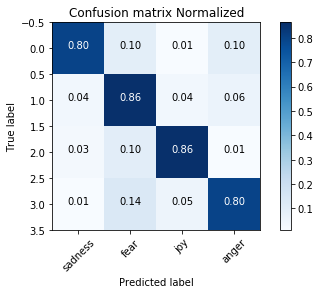

In [21]:
word_embeddings.predict(count_vectorizer, logreg_model, test_data, my_tags)

In [24]:
# words for the emotion of anger
anger_tag_id = word_embeddings.get_tag_index(my_tags, "anger") 
anger_words,_ = word_embeddings.most_influential_words(logreg_model, count_vectorizer, \
                                                      anger_tag_id, 3000)
anger_words = pd.DataFrame(anger_words, columns=['word', 'importance'])

In [26]:
# Please show the top 10 anger word

,word,importance
0,sober,3.390150
1,blues,3.223902
2,depressing,3.194138
3,unhappy,3.164551
4,dark,3.160466
5,pine,2.982316
6,grim,2.976784
7,depression,2.976086
8,stayed,2.972564
9,dull,2.903308


In [27]:
# words for the emotion of fear
fear_tag_id = word_embeddings.get_tag_index(my_tags, "fear") 
fear_words, _ = word_embeddings.most_influential_words(logreg_model, count_vectorizer, \
                                                      fear_tag_id, 3000)
fear_words = pd.DataFrame(fear_words, columns=['word', 'importance'])

In [21]:
# Please show the top 10 fear word

,0,1
0,nightmare,2.956958
1,terrorism,2.797460
2,bully,2.757401
3,horror,2.705798
4,nervous,2.680294
5,panic,2.654843
6,fear,2.629041
7,shy,2.552379
8,horrific,2.547849
9,horrible,2.546344


In [29]:
# check overlap of words and their index
word_embeddings.check_word_overlap(anger_words[:500]['word'], fear_words[:500]['word'])

[[['dreadful', 33],
  ['idea', 133],
  ['rich', 223],
  ['honestly', 290],
  ['bake', 362],
  ['amateurs', 381],
  ['going', 398],
  ['starting', 412]],
 8]

In [32]:
# pip install matplotlib_venn
from matplotlib_venn import venn2

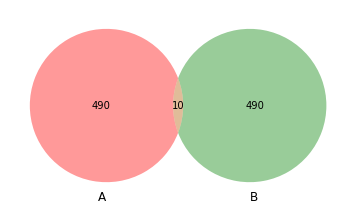

In [29]:
venn2([set(anger_words[:500][0].tolist()), set(fear_words[:500][0].tolist())])
plt.show()

You may notice that even though the words overlap some of them are not even related to any of the emotions, therefore, we can improve this model. What would happen if we just remove the overlapping words?

#### Character N-grams
A character n-gram is a chunk of a document of length n. It is a poor man's tokenizer but sometimes works well. The parameter n depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones. 3K is a fair comparison since the previous bag of words model was this size as well.

In [33]:
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

charn_model = linear_model.LogisticRegression()

train_data_features = n_gram_vectorizer.fit_transform(train_data['text'])

charn_model = charn_model.fit(train_data_features, train_data['emotion'])

/Users/yenhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yenhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [34]:
### observe some features
n_gram_vectorizer.get_feature_names()[100:110]

[' bec',
 ' beca',
 ' bee',
 ' been',
 ' bei',
 ' bein',
 ' bet',
 ' bi',
 ' bl',
 ' bla']

accuracy 0.6685878962536023
              precision    recall  f1-score   support

     sadness       0.62      0.72      0.66        74
        fear       0.69      0.67      0.68       110
         joy       0.74      0.61      0.67        79
       anger       0.65      0.68      0.66        84

    accuracy                           0.67       347
   macro avg       0.67      0.67      0.67       347
weighted avg       0.67      0.67      0.67       347

(row=expected, col=predicted)


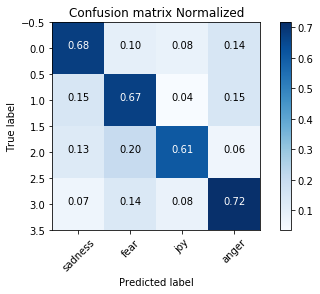

In [35]:
word_embeddings.predict(n_gram_vectorizer, charn_model, test_data, my_tags)

You can notice that the char n-gram model doesn't perform as well as the bag of words model.

**Exercise:** Try to improve the model by removing stopwords; or try other techniques you have learned so far.

In [36]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yenhao/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
stops = stopwords.words("english")
stops[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
### TRY

#### TF-IDF
Term Frequency - Inverse Document Frequency is useful to rank importance of words to documents

In [38]:
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['text'])

tfidf_model = linear_model.LogisticRegression()
tfidf_model = tfidf_model.fit(train_data_features, train_data['emotion'])

/Users/yenhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yenhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [39]:
tf_vect.get_feature_names()[100:110]

['1nataliemaines',
 '1st',
 '2',
 '2-3',
 '20',
 '2014',
 '2015.',
 '2016',
 '23',
 '28th']

In [40]:
len(tf_vect.get_feature_names())

4460

accuracy 0.8328530259365994
              precision    recall  f1-score   support

     sadness       0.84      0.78      0.81        74
        fear       0.76      0.90      0.82       110
         joy       0.88      0.85      0.86        79
       anger       0.92      0.77      0.84        84

    accuracy                           0.83       347
   macro avg       0.85      0.83      0.83       347
weighted avg       0.84      0.83      0.83       347

(row=expected, col=predicted)


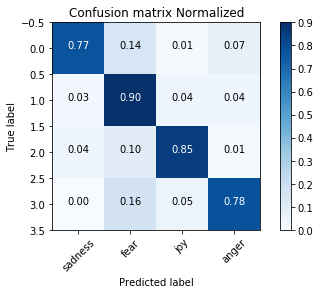

In [41]:
word_embeddings.predict(tf_vect, tfidf_model, test_data, my_tags)

Let us perform some further analysis on the TF-IDF model.

In [42]:
# words for the anger emotion
anger_tag_id = word_embeddings.get_tag_index(my_tags, "anger")
anger_words,_ = word_embeddings.most_influential_words(tfidf_model, tf_vect, anger_tag_id, 3000)
anger_words[0:10]

[['lost', 4.5118014467638305],
 ['sober', 4.0137414271940255],
 ['unhappy', 3.893484313477551],
 ['blues', 3.886537511689392],
 ['sad', 3.879510122670166],
 ['depression', 3.8546993826790734],
 ['dark', 3.702090892381053],
 ['depressing', 3.6595029078895105],
 ['grim', 3.4838455528860184],
 ['sadness', 3.199482528405074]]

In [43]:
# words for the joy
joy_tag_id = word_embeddings.get_tag_index(my_tags, "joy")
joy_words,_ = word_embeddings.most_influential_words(tfidf_model, tf_vect, joy_tag_id, 3000)
joy_words[0:10]

[['happy', 4.156731893119143],
 ['hilarious', 4.13900100042193],
 ['optimism', 4.071284628227457],
 ['glee', 3.7911738742857493],
 ['smile', 3.736907036773446],
 ['elated', 3.259719996433941],
 ['lively', 3.217244621696579],
 ['cheering', 3.2076685084316496],
 ['laughter', 3.0984495662428735],
 ['cheer', 3.014897930813876]]

**Exercise:** Head to scikit-learn webiste and learn how to use different parameters for the TF-IDF vectorizer, such as modifying the ngram_range. It might improve the performance of the classifier.

---

### Averaging Word Vectors (word2vec model)

**SOURCE:** https://code.google.com/archive/p/word2vec/

First, we are going to use a pretrained model provided as open source by Google (word2vec)

In [45]:
wv = gensim.models.KeyedVectors.load_word2vec_format(
    "data/word2vec/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

**Pre-processing** Here we tokenize both the training and testing datasets before creating the vectors with word2vec. Think of this as a filtering step. In this case words with len(word)<2 are removed.

In [47]:
test_tokenized = test_data.apply(lambda r: word2vec_helpers.w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train_data.apply(lambda r: word2vec_helpers.w2v_tokenize_text(r['text']), axis=1).values

In [48]:
test_tokenized[0:10]

array([list(['TheDappaMc', 'also', '£2.50', 'for', 'chocolate', 'Feast', 'ice', 'lolly..', 'proper', 'shocking']),
       list(['Season', 'and', 'Charlie', 'is', 'still', 'prick', 'lost']),
       list(['Just', 'joined', 'pottermore', 'and', 'was', 'sorted', 'into', 'HUFFLEPUFF', '😡😡😡']),
       list(['Staff', 'on', 'ryainair', 'FR1005', 'Asked', 'for', 'info', 'and', 'told', 'to', 'look', 'online', 'You', 'get', 'what', 'you', 'pay', 'for', 'Ryanair', 'STN_Airport', 'Compensation']),
       list(['Having', 'baby', 'born', 'too', 'soon', 'is', 'lifechanging', 'years', 'on', 'and', 'it', 'feels', 'like', 'only', 'yesterday', 'sad', 'happy', 'angry', 'emotionalrollercoaster']),
       list(['airtelindia', 'have', 'some', 'issues', 'with', 'my', 'broadband', 'bill', 'am', 'charged', 'for', 'the', 'month', 'before', 'signed', 'up', 'with', 'airtel..']),
       list(['think', 'Sam_Canaday', 'amp', 'KYLEJDOWSON', 'must', 'actually', 'have', 'to', 'be', 'working', 'like', 'me', 'amp', 'dowson

Next, we have to convert the words into a distributed representation (in other words, each token must be converted into its vector representation obtained from word2vec). Since we are using a pretrained word2vec the conversion can be done easily. 

Now that we have the word embeddings, we can obtain vectors for an entire document, by averaging word vectors. (Warning: very naive approach!)

![alt txt](https://docs.google.com/drawings/d/1m1Uod7QU4iSN7J3iqsTU6JRWdGTEJRZ2dA7rZrgNHgA/pub?w=942&h=375)

In [49]:
### Here we average the word vectors
X_train_word_average = word2vec_helpers.word_averaging_list(wv,train_tokenized)
X_test_word_average = word2vec_helpers.word_averaging_list(wv,test_tokenized)

In [50]:
X_train_word_average[0]

array([-0.00981353,  0.04685079,  0.01353307,  0.10336746,  0.02854822,
       -0.01011848,  0.03698618, -0.08231089,  0.05494837,  0.0831644 ,
       -0.11720615, -0.11529852, -0.05327908, -0.01858655, -0.03770043,
        0.01669143,  0.04688344,  0.02879405, -0.03084578, -0.02492736,
        0.01945293,  0.10359719,  0.00889932, -0.00903256,  0.09378658,
       -0.01635875,  0.01310255,  0.07307018,  0.07141641,  0.0819335 ,
       -0.0293961 ,  0.0165843 , -0.01296143, -0.01399172,  0.1024896 ,
       -0.05982228, -0.08594035, -0.02419597,  0.06685761,  0.05199094,
        0.13110274, -0.02556262,  0.01966236,  0.04114237, -0.00315835,
       -0.04080563, -0.02902514, -0.03744263,  0.05658067, -0.03166691,
        0.02007939,  0.0327605 ,  0.07251233,  0.08175123,  0.01997067,
        0.00322222, -0.01067198, -0.03395844,  0.04087894,  0.00664813,
       -0.05234237,  0.04821053, -0.0917882 , -0.08820268,  0.0554884 ,
        0.0421812 ,  0.01932958,  0.11322453,  0.05995444,  0.09

**Further exploration of word2vec generated vectors**

Some tips here: https://radimrehurek.com/gensim/models/keyedvectors.html

In [51]:
### obtain vector for a specific word
wv['unhappy']

array([ 7.44407773e-02,  5.99248260e-02, -1.14452699e-02, -9.60286036e-02,
       -6.58800900e-02,  8.22570622e-02,  3.55454721e-02, -1.34923914e-02,
        6.36468679e-02,  9.82618257e-02, -4.52227741e-02, -9.44467355e-03,
       -3.59176770e-02,  4.80143018e-02, -3.16373296e-02,  5.06197289e-02,
        7.18353540e-02,  1.92615520e-02,  2.38210484e-02, -8.88636801e-03,
       -2.18669791e-02,  8.93289372e-02,  1.46090025e-02,  1.07008619e-02,
        1.19105242e-01,  4.76420969e-02,  7.58365449e-03,  1.37715442e-02,
        9.04455483e-02, -5.84360100e-02,  6.21580519e-02, -3.23817395e-02,
        5.54583818e-02,  9.49119963e-03,  1.11661166e-01, -8.33736733e-02,
        9.67730135e-02,  3.25678401e-02, -3.85231040e-02,  4.24312428e-02,
        3.77786942e-02, -1.43298497e-02, -7.67670525e-03, -8.52346942e-02,
       -5.21085449e-02, -1.04961500e-01, -4.42922637e-02,  3.59176770e-02,
       -7.22075552e-02, -5.95526211e-03, -7.36963674e-02, -1.39576457e-02,
       -2.73569860e-02, -

Other fun operations you can do with word2vec model

In [52]:
wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

In [53]:
wv.most_similar(positive=['GOP', 'Trump'], negative=['money'])

[('Republican', 0.5712672472000122),
 ('Republicans', 0.5465080738067627),
 ('Donald_Trump', 0.5382609367370605),
 ('Gingrich', 0.5238125920295715),
 ('Palin', 0.5126574039459229),
 ('Santorum', 0.4977916479110718),
 ('Dems', 0.49728360772132874),
 ('Democratic', 0.49602845311164856),
 ('GOPers', 0.4934149980545044),
 ('Democrats', 0.4912266731262207)]

**Exercise:** Try to research mode about the intuition behind these operations and try to come up with more interesting ones.

For fun, let us try to manually compute the cosine similarity of some of our word vectors, which is computed as follows:

![alt txt](https://docs.google.com/drawings/d/1QI_5_uxopOYgk2PzU_RMTUGKkoNhJp81aIz4SUwsHIM/pub?w=956&h=263)

In [54]:
word_embeddings.cosine_measure(wv['gun'], wv['pistol'])

0.7692407558643691

**Exercise:** Try to find cosine similarity between emotion related words. 

In [ ]:
####

---

### KNN Classification

Now we train a KNN and a logistic regression classifier and observe how they perfom on these word-averaging document features

Read about KNN- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

![alt txt](https://docs.google.com/drawings/d/13xu1RP3pVem277_eT900af7iz_MvTQUrLoxzWAewb_o/pub?w=817&h=614)

In [55]:
### train model
knn_naive_dv = KNeighborsClassifier(n_neighbors=10, n_jobs=-1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.emotion)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                     weights='uniform')

In [56]:
### obtain predictions on test data
predicted = knn_naive_dv.predict(X_test_word_average)

accuracy 0.4755043227665706
              precision    recall  f1-score   support

     sadness       0.44      0.42      0.43        74
        fear       0.54      0.56      0.55       110
         joy       0.46      0.43      0.44        79
       anger       0.43      0.45      0.44        84

    accuracy                           0.48       347
   macro avg       0.47      0.47      0.47       347
weighted avg       0.47      0.48      0.47       347

(row=expected, col=predicted)


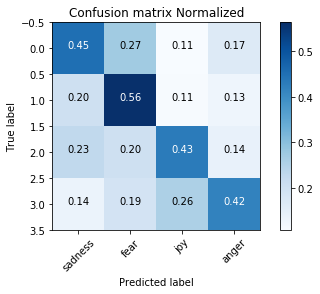

In [57]:
### evaluate the model
word_embeddings.evaluate_prediction(predicted, test_data.emotion, my_tags)

In [ ]:
### Try a best result

You can see that K-Neareset Neighbour doesn't perform well when using the average vector representations (obtained from pretrained word2vec) of the text data. This is partly because the pretrained word2vec may not be helping with the task at hand. What if we train our own word2vec using our dataset? (We need a lot of data!)

In [58]:
test_data.iloc()[56]['text']

'@LeePorter94 @DomMcGovern_ hi Dom I saw u at Notts county away, looking for 1 mufc away ticket will pay #blues'

In [59]:
wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]

[('just', 0.5695096850395203),
 ('going', 0.5413254499435425),
 ('away', 0.5349320769309998),
 ('want', 0.5213906764984131),
 ("'ll", 0.5139321088790894),
 ('for', 0.5131220817565918),
 ('back', 0.5110349655151367),
 ('do', 0.487600177526474),
 ('get', 0.4861181676387787),
 ('out', 0.48536404967308044),
 ('got', 0.4818972945213318),
 ('at', 0.4795985817909241),
 ('saw', 0.4787687063217163),
 ('see', 0.4786507487297058),
 ("'d", 0.47812792658805847),
 ('anyway', 0.4753376841545105),
 ('they', 0.464893639087677),
 ('then', 0.4603482484817505),
 ('somewhere_else', 0.45942801237106323),
 ('could', 0.4573122262954712)]

The problem with the result is that the average of this particular document falls under some area that is not related to the overall emotion portrayed by the original document.

---

### Doc2Vec
Paper: https://cs.stanford.edu/~quocle/paragraph_vector.pdf
It is a **semi-supervised** approach since a **weak label or tag** (you can put many) is introduced into training documents before modeling. Read more about semi-supervised appraoches here: https://en.wikipedia.org/wiki/Semi-supervised_learning

![alt txt](https://docs.google.com/drawings/d/1TT6jNhk8rVoWMQajb8AIXCtyug0t_YVVZrvFidDPUPU/pub?w=679&h=375)

In [60]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [61]:
### First we tag each text with its emotion
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=word_embeddings.tokenize_text(r['text']), tags=[r.emotion]), axis=1)

In [62]:
train_tagged.head(4)

533    ([watch, this, amazing, live.ly, broadcast, by...
638    ([bbs_coffee, somebody, needs, tell, staff, at...
531    ([the, quarterback, wrecks, me, every, time..,...
525    ([dl_hart, donniedollars, aaronbiggspro, wweno...
dtype: object

In [63]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=word_embeddings.tokenize_text(r['text']), tags=[r.emotion]), axis=1)

In [64]:
test_tagged.values[2]

TaggedDocument(words=['just', 'joined', 'pottermore', 'and', 'was', 'sorted', 'into', 'hufflepuff', '😡😡😡'], tags=['anger'])

In [65]:
# transform into proper format
trainsent = train_tagged.values
testsent = test_tagged.values

In [66]:
trainsent

array([TaggedDocument(words=['watch', 'this', 'amazing', 'live.ly', 'broadcast', 'by', 'matt.boss', 'musicallyjh'], tags=['joy']),
       TaggedDocument(words=['bbs_coffee', 'somebody', 'needs', 'tell', 'staff', 'at', 'reading', 'cappuccino', 'is', 'supposed', 'to', 'have', 'thick', 'layer', 'of', 'foam', 'and', 'coffee', 'should', 'be', 'hot', 'awful', 'again'], tags=['fear']),
       TaggedDocument(words=['the', 'quarterback', 'wrecks', 'me', 'every', 'time..', 'glee'], tags=['joy']),
       ...,
       TaggedDocument(words=['delhi_lawyer', 'bhagwanuvach', 'shivaroor', 'sad', 'this', 'is', 'not', 'film', 'story', 'who', 'knows', 'could', 'be', 'ploy', 'to', 'escalate', 'tension', 'unverified', 'report', 'no', 'hype'], tags=['sadness']),
       TaggedDocument(words=['sxmurbanview', 'karenhunter', 'cousinsyl', 'you', 'are', 'so', 'wrong', 'for', 'this', 'needed', 'levity', 'after', 'that', 'recording'], tags=['joy']),
       TaggedDocument(words=['amymek', 'this', 'is', 'so', 'absurd',

In [67]:
# train the model with simple gensim doc2vec api
# size (dimensions of features)
# dm is the training algorithm (distribute memory (1) or distributed bag of words)
doc2vec_model = Doc2Vec(trainsent, workers=4, size=200, iter=25, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

/Users/yenhao/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/yenhao/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
2019-11-07 01:05:11,817 : INFO : collecting all words and their counts
2019-11-07 01:05:11,818 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-11-07 01:05:11,843 : INFO : collected 10712 word types and 4 unique tags from a corpus of 3613 examples and 56368 words
2019-11-07 01:05:11,844 : INFO : Loading a fresh vocabulary
2019-11-07 01:05:11,850 : INFO : effective_min_count=5 retains 136

2019-11-07 01:05:15,469 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-07 01:05:15,472 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-07 01:05:15,538 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-07 01:05:15,551 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-07 01:05:15,552 : INFO : EPOCH - 14 : training on 56368 raw words (34921 effective words) took 0.3s, 137481 effective words/s
2019-11-07 01:05:15,752 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-07 01:05:15,756 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-07 01:05:15,804 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-07 01:05:15,818 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-07 01:05:15,819 : INFO : EPOCH - 15 : training on 56368 raw words (34948 effective words) took 0.3s, 134353 effective words/s
2019

In [68]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

Let us see what our data looks like after training and transormations

In [69]:
test_targets[0:5]

('fear', 'sadness', 'anger', 'fear', 'anger')

In [70]:
test_regressors[0:2]

(array([ 1.54733080e-02, -2.79284585e-02,  1.37472451e-02,  3.23264487e-03,
        -3.78050171e-02, -6.00856123e-03,  5.74007817e-03, -7.20044039e-03,
        -1.97561644e-03,  1.14161586e-02,  1.36520006e-02,  1.35033233e-02,
         1.54799446e-02,  4.99391370e-03,  2.13409290e-02,  2.63746753e-02,
         4.77306172e-03, -1.16368989e-02, -1.77999306e-02,  2.75046173e-02,
        -1.22490758e-02,  8.68049078e-03, -4.37473971e-03,  1.57573596e-02,
        -9.15246643e-03,  4.85644070e-03,  5.40769612e-03, -3.04812267e-02,
         1.69085581e-02,  1.60588026e-02,  2.29055844e-02, -8.75774771e-03,
        -3.25606414e-03,  3.72987197e-05, -5.32148313e-03, -2.83559747e-02,
         3.47509086e-02, -4.68576048e-03, -2.56040841e-02, -1.55449631e-02,
        -1.55824916e-02,  2.48122178e-02, -1.47096917e-03,  1.05130989e-02,
        -2.10546143e-02, -2.00865022e-03, -6.34302525e-03, -1.00374110e-02,
        -1.00626275e-02, -3.53367962e-02,  1.37114972e-02, -1.44463675e-02,
         1.3

In [71]:
# train a logistic regression model
d2v_model = linear_model.LogisticRegression()
d2v_model = d2v_model.fit(train_regressors, train_targets)

/Users/yenhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yenhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.7665706051873199
              precision    recall  f1-score   support

     sadness       0.75      0.68      0.71        74
        fear       0.73      0.82      0.77       110
         joy       0.79      0.78      0.79        79
       anger       0.81      0.76      0.79        84

    accuracy                           0.77       347
   macro avg       0.77      0.76      0.76       347
weighted avg       0.77      0.77      0.77       347

(row=expected, col=predicted)


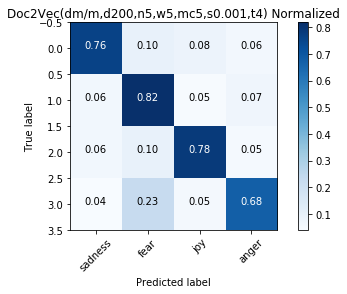

In [72]:
word_embeddings.evaluate_prediction(d2v_model.predict(test_regressors), test_targets, my_tags,title=str(doc2vec_model))

Now let us train KNN model with doc2vec.

2019-11-07 01:06:37,331 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.7463976945244957
              precision    recall  f1-score   support

     sadness       0.73      0.72      0.72        74
        fear       0.76      0.72      0.74       110
         joy       0.68      0.80      0.73        79
       anger       0.83      0.76      0.80        84

    accuracy                           0.75       347
   macro avg       0.75      0.75      0.75       347
weighted avg       0.75      0.75      0.75       347

(row=expected, col=predicted)


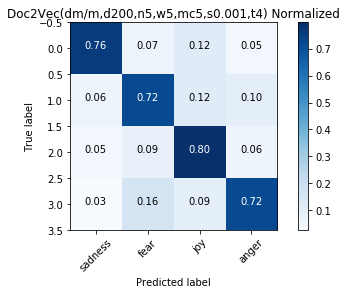

In [73]:
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
word_embeddings.evaluate_prediction(knn_test_predictions, test_targets,my_tags, str(doc2vec_model))

Since doc2vec also gives us a vector for each genre, we can also observe which genres are similar to each other

In [74]:
doc2vec_model.docvecs.most_similar('anger')

[('sadness', 0.16925787925720215),
 ('fear', 0.16002407670021057),
 ('joy', 0.13885614275932312)]

In [75]:
doc2vec_model.docvecs.most_similar('fear')

[('sadness', 0.18291889131069183),
 ('anger', 0.16002407670021057),
 ('joy', 0.15531319379806519)]

Since words and categories fall in the same vector space, it is possible to also observe which words sorround a tag. Notice how well those words describe the tag.

In [76]:
doc2vec_model.most_similar([doc2vec_model.docvecs['joy']])

/Users/yenhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-11-07 01:07:33,179 : INFO : precomputing L2-norms of word weight vectors


[('strength', 0.9765412211418152),
 ('victory', 0.9733200669288635),
 ('radio', 0.9353652000427246),
 ('beautiful', 0.9344692230224609),
 ('gloomy', 0.9290280342102051),
 ('determined', 0.9238399267196655),
 ('artist', 0.9213887453079224),
 ('thenicebot', 0.920090913772583),
 ('water', 0.9159512519836426),
 ('inspiration', 0.914232611656189)]

### Visualization
We will visualize embeddings using a popular algorithm called T-SNE, which is very similar to the dimentionality reduction algorithm called PCA.

In [77]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [78]:
### unpacking words from the dco2vec model trained
doc2vec_words = word2vec_helpers.unpack_words_from_doc_vector(doc2vec_model)

**Exercise:** Try to visualize words and find interesting clusters. There are so many creative ways to visualize these powerful vector representations. You can also try other type of classifiers and apply other improvements in the preprocessing stages.

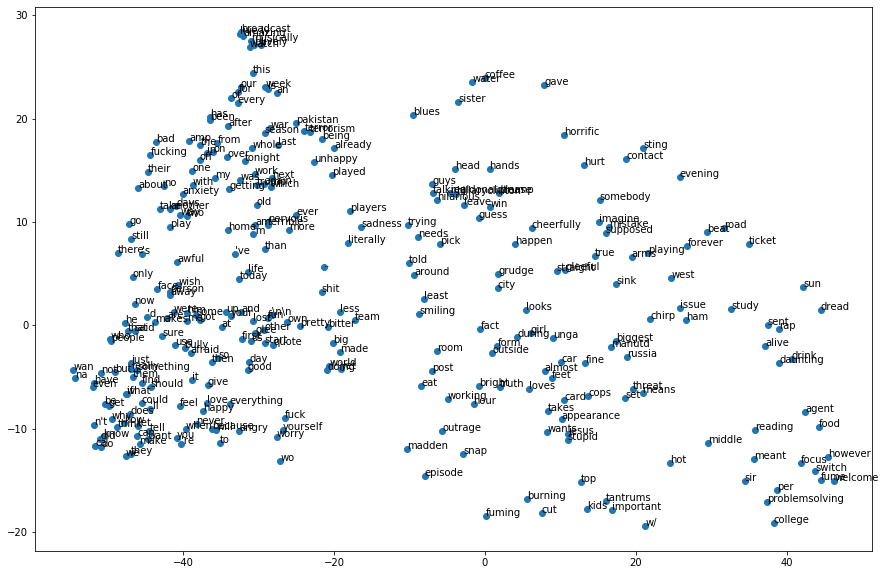

In [79]:
word2vec_helpers.visualize_vectors(doc2vec_model, doc2vec_words)

## Clustering

In [80]:
from sklearn import cluster

### K-means

In [81]:
kmean_cluster = cluster.KMeans(n_clusters = 4) # 4 emotion

#### bow cluster

In [82]:
kmeans_fit_bow = kmean_cluster.fit(train_data_features)

In [83]:
# Clustering Result
cluster_labels_bow = kmeans_fit_bow.labels_
cluster_labels_bow[:20]

array([1, 0, 0, 3, 2, 2, 0, 0, 0, 2, 0, 0, 3, 2, 0, 2, 0, 0, 0, 0],
      dtype=int32)

Try again! What do you see?!

In [84]:

kmeans_fit_bow = kmean_cluster.fit(train_data_features)
cluster_labels_bow = kmeans_fit_bow.labels_
cluster_labels_bow[:20]

array([3, 0, 0, 1, 2, 3, 0, 0, 0, 3, 0, 2, 1, 3, 0, 3, 2, 2, 0, 0],
      dtype=int32)

#### convert categories to number

In [85]:
train_data.emotion = pd.Categorical(train_data.emotion)
train_data['emotion_label'] = train_data.emotion.cat.codes
train_data['emotion_label'].tolist()[:20]

[2, 1, 2, 0, 3, 1, 1, 2, 0, 3, 3, 2, 1, 2, 1, 3, 0, 1, 1, 0]

In [86]:
from sklearn.decomposition import PCA

In [87]:
X_reduced = PCA(n_components=2).fit_transform(train_data_features.toarray())

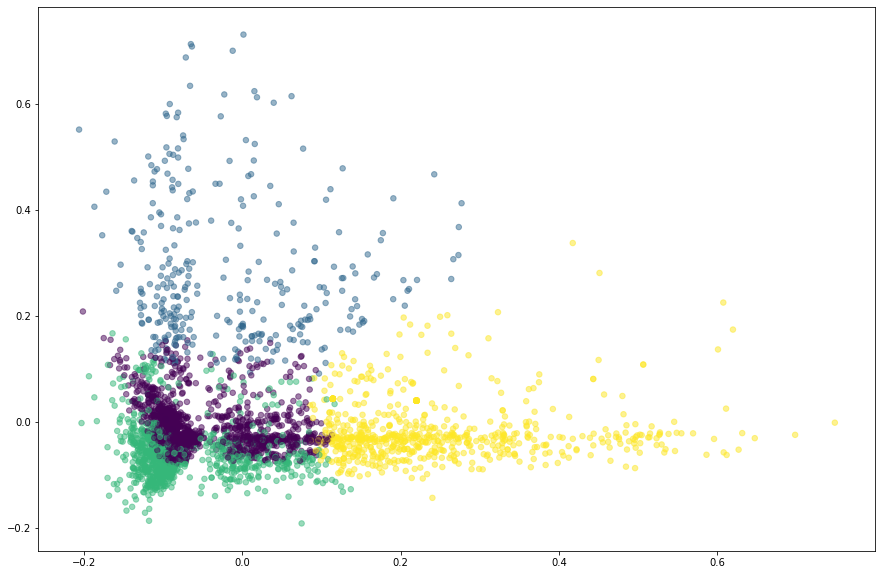

In [88]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels_bow, s=30, alpha=0.5, cmap='viridis')

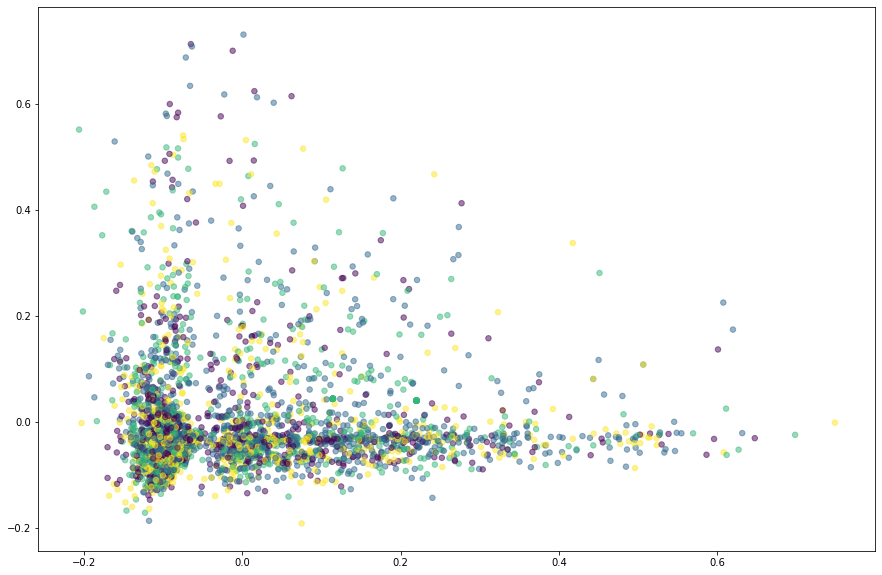

In [89]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_data['emotion_label'].tolist(), s=30, alpha=0.5, cmap='viridis')

In [90]:
from mpl_toolkits.mplot3d import Axes3D

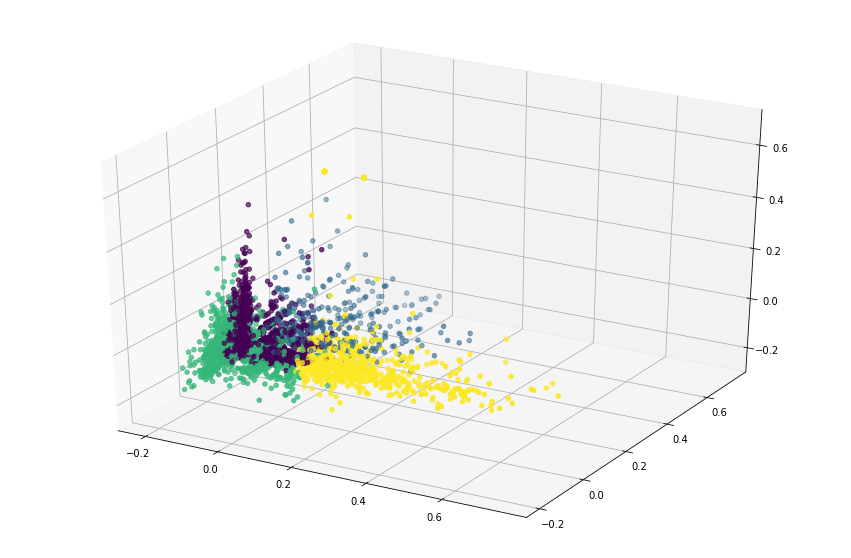

In [91]:
X_reduced = PCA(n_components=3).fit_transform(train_data_features.toarray())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=cluster_labels_bow, cmap='viridis')
plt.show()
plt.close()

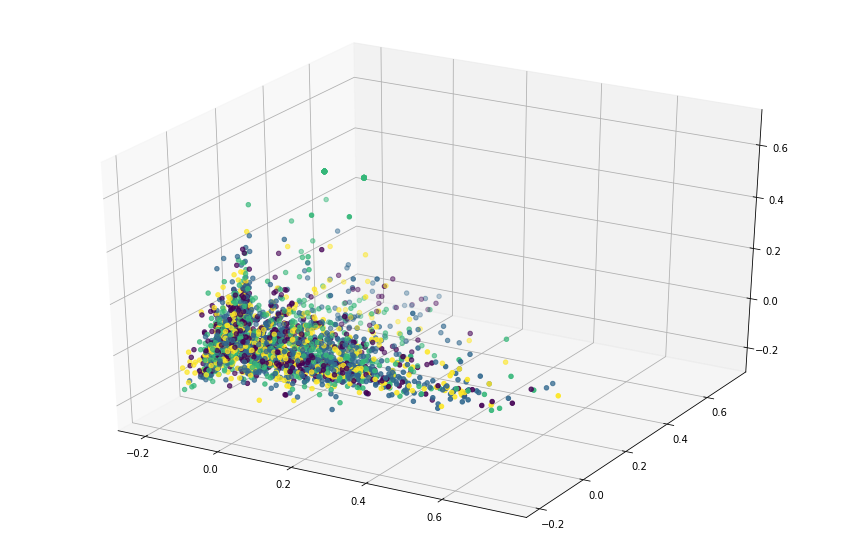

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=train_data['emotion_label'].tolist(), cmap='viridis')
plt.show()
plt.close()

#### Word2vec cluster

In [93]:
kmeans_fit_w2v = kmean_cluster.fit(X_train_word_average)
# Clustering Result
cluster_labels_w2v = kmeans_fit_w2v.labels_
cluster_labels_w2v[:20]

array([3, 0, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2],
      dtype=int32)

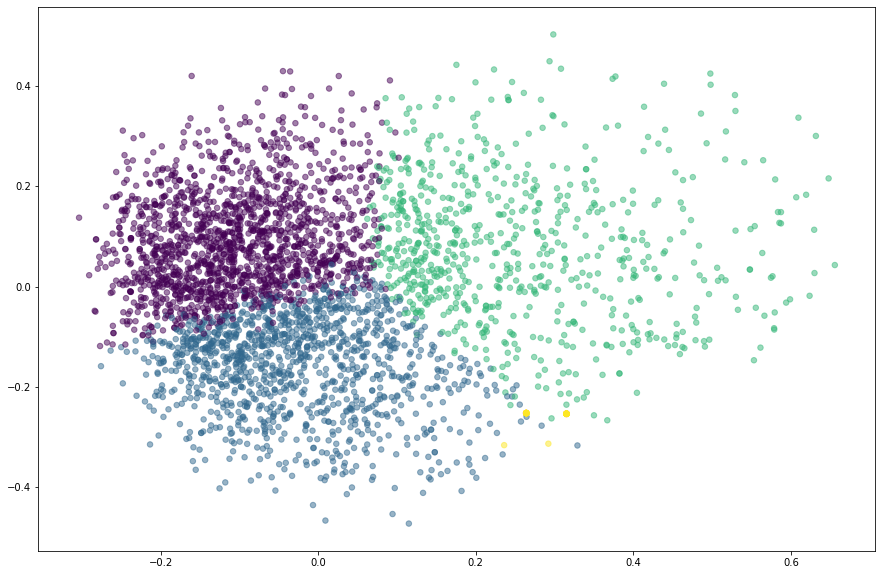

In [94]:
### Please draw the scatter for word2vec and predict label
X_reduced = PCA(n_components=2).fit_transform(X_train_word_average)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels_w2v, s=30, alpha=0.5, cmap='viridis')

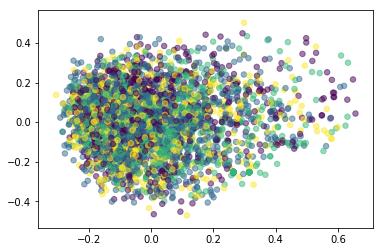

In [100]:
# please show the scatter for emotion label


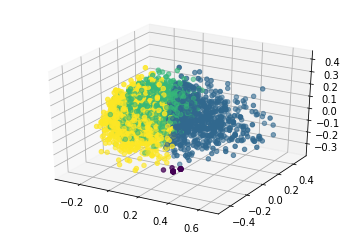

In [119]:
# Plot both graph for 3d with clustering label


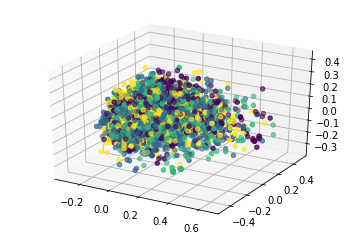

In [102]:
# Plot both graph for 3d with emotion label


### how to determine is it a good cluster

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). The best value is 1 and the worst value is -1.

In [97]:
# performance of bow cluster
silhouette_score(train_data_features, cluster_labels_bow)

0.010324481378388912

In [98]:
# performance of w2v cluster
silhouette_score(X_train_word_average, cluster_labels_w2v)

0.039923117

#### How many K?

In [ ]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(train_data_features.toarray())
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = silhouette_score(train_data_features.toarray(), cluster_labels)
    silhouette_avgs.append(silhouette_avg)


plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

In [ ]:
### Please show what is the best K for word2vec

#### Plot the clustering result with the best K

In [ ]:
### YOUR CODE

### DBSCAN

Decide how many clusters itself

In [ ]:
db_cluster = cluster.DBSCAN(eps=2, min_samples=5, n_jobs=4)
db_cluster_bow = db_cluster.fit(train_data_features.toarray())
# np.unique(db_cluster_w2v.labels_)
labels = db_cluster_bow.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

In [ ]:
# Plot both graph for 3d ones
X_reduced = PCA(n_components=3).fit_transform(train_data_features.toarray())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, alpha=0.3, cmap='viridis')
plt.show()
plt.close()

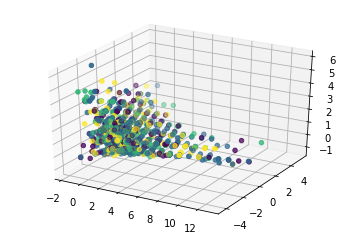

In [187]:
# Plot both graph for 3d with emotion label


In [ ]:
db_cluster = cluster.DBSCAN(eps=0.5, min_samples=5)
db_cluster_w2v = db_cluster.fit(X_train_word_average)
# np.unique(db_cluster_w2v.labels_)
labels = db_cluster_w2v.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

In [ ]:
# Plot both graph for 3d ones
X_reduced = PCA(n_components=3).fit_transform(X_train_word_average)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis')
plt.show()
plt.close()

In [ ]:
# Plot both graph for 3d ones
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=train_data['emotion_label'].tolist(), cmap='viridis')
plt.show()
plt.close()